In [1]:
%load_ext autoreload
%autoreload 2

#general imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time as tt
import mogptk


#our package
from gpinit import *
import utils 

In [2]:
#generate synthetic data (2-component specrtal mixture)

#np.random.seed(1)

t0 = 0
tf = 2000
Nobs = 5000

#define time    
time = t0 + (tf-t0)*np.random.rand(Nobs)
ind = np.unravel_index(np.argsort(time, axis=None), time.shape)
time = time[ind]

#instantiate gp & set the true params
q = 2 # order of the spectral mixture
gp0 = gpinit(space_input=time, aim = 'sampling', kernel = 'qSM', order = q)
theta = np.array((2,0.0001,0.02,2,0.0001,0.03, 1)) # sigma, gamma, mu, sigma_n
gp0.theta = theta

#generate and split dataset
signal = gp0.sample(time)


In [3]:
#define error function
def param_error(y_true, y_pred, model):
    error1 = np.abs(theta[-1] - np.sqrt(model.gpr.likelihood.scale.numpy()))/np.abs(theta[-1])
    error2 = np.abs(theta[-1] - np.sqrt(model.gpr.likelihood.scale.numpy()))/np.abs(theta[-1])
    
    for i in range(2):
        error1 += np.abs(theta[3*i] - model.gpr.kernel[i].magnitude.numpy())/np.abs(theta[3*i]) #sigma
        error1 += np.abs(theta[3*i+1] - 2*np.pi**2*model.gpr.kernel[i].variance.numpy())/np.abs(theta[3*i+1]) #gamma
        error1 += np.abs(theta[3*i+2] - model.gpr.kernel[i].mean.numpy())/np.abs(theta[3*i+2]) #mu
        
        error2 += np.abs(theta[3*(1-i)] - model.gpr.kernel[i].magnitude.numpy())/np.abs(theta[3*(1-i)]) #sigma
        error2 += np.abs(theta[3*(1-i)+1] - 2*np.pi**2*model.gpr.kernel[i].variance.numpy())/np.abs(theta[3*(1-i)+1]) #gamma
        error2 += np.abs(theta[3*(1-i)+2] - model.gpr.kernel[i].mean.numpy())/np.abs(theta[3*(1-i)+2]) #mu
    
    return min(error1,error2)

In [4]:
## train models and measure execution times


runs = 50
model0_times = []
model0_nll = []
model0_errors = []
model1_times = []
model1_nll = []
init_times = []
model1_errors = []


for i in range(runs):
    ##set random initial condition
    print(f'executing run: {i}')
    np.random.seed(None)
    theta_0 = theta*0.5 + 1.0*np.random.rand(len(theta))*theta
    time_train, time_test, signal_train, signal_test = train_test_split(time, signal, test_size=0.8)



    ##train using ML (MOGPTK)
    data = mogptk.LoadSplitData(time_train, time_test, signal_train, signal_test)
    data.transform(mogptk.TransformDetrend(degree=0))
    kernel = mogptk.gpr.MixtureKernel(mogptk.gpr.SpectralKernel(), Q=q)
    #pass initial condition
    for i in range(q):
        kernel[i].magnitude.assign(theta_0[3*i+0])
        kernel[i].variance.assign(theta_0[3*i+1]/(2*np.pi**2))
        kernel[i].mean.assign(theta_0[3*i+2])    
    inference = mogptk.Exact(variance=theta_0[-1])
    #instantiate model, train and store
    model_0 = mogptk.Model(data, kernel, inference)
    model_0.train(method='LBFGS', error=param_error, tolerance_change=1e-3, lr=0.1, verbose=False);
    model0_times.append(model_0.times)
    model0_nll.append(model_0.losses)
    model0_errors.append(model_0.errors)
    
    
    ##initialise using proposed method from theta_0
    #instantiate model
    gp = gpinit(space_input=time_train,space_output=signal_train, time_test = time_test, y_test = signal_test, aim = 'learning', kernel = 'qSM', order = q)#SE
    #set frequencies (optional)
    freqs = np.linspace(0,0.06,2000)
    gp.set_freqs(freqs)
    #pass init params
    gp.theta = theta_0
    #train
    t0 = tt.time()
    gp.initialise(metric='L2')
    init_times.append(tt.time()-t0)
    
    
    ##train using ML from initialised model
    #override previously learnt params
    for i in range(q): 
        kernel[i].magnitude.assign(gp.theta[3*i+0])
        kernel[i].variance.assign(gp.theta[3*i+1]/(2*np.pi**2))
        kernel[i].mean.assign(gp.theta[3*i+2])
    inference = mogptk.Exact(variance=gp.theta[-1]**2)

    #instantiate new model, train and store
    model_1 = mogptk.Model(data, kernel, inference)
    model_1.train(method='LBFGS', error=param_error, tolerance_change=1e-3, lr=0.1, verbose=False);
    model1_times.append(model_1.times)
    model1_nll.append(model_1.losses)
    model1_errors.append(model_1.errors)




executing run: 0
executing run: 1
executing run: 2
executing run: 3
executing run: 4
executing run: 5
executing run: 6
executing run: 7
executing run: 8
executing run: 9
executing run: 10
executing run: 11
executing run: 12
executing run: 13
executing run: 14
executing run: 15
executing run: 16
executing run: 17
executing run: 18
executing run: 19
executing run: 20
executing run: 21
executing run: 22
executing run: 23
executing run: 24
executing run: 25
executing run: 26
executing run: 27
executing run: 28
executing run: 29
executing run: 30
executing run: 31
executing run: 32
executing run: 33
executing run: 34
executing run: 35
executing run: 36
executing run: 37
executing run: 38
executing run: 39
executing run: 40
executing run: 41
executing run: 42
executing run: 43
executing run: 44
executing run: 45
executing run: 46
executing run: 47
executing run: 48
executing run: 49


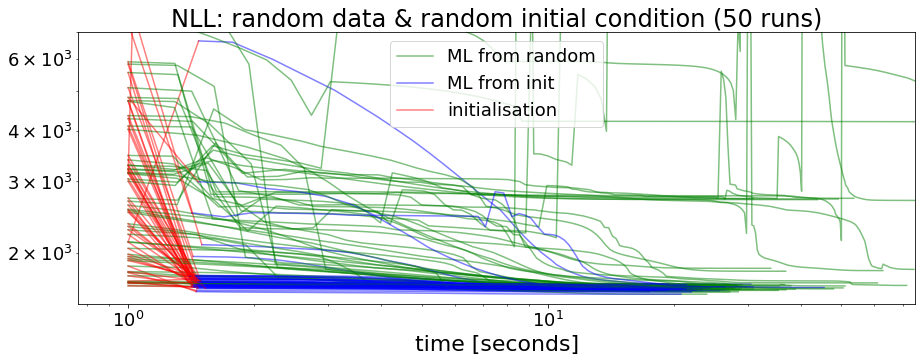

In [31]:
#plots
for i in range(runs):  
    plt.loglog(1+model0_times[i]-model0_times[i][0],model0_nll[i], 'g', alpha=0.5, label = "ML from random" if i == 0 else "")
    plt.loglog(1+model1_times[i]-model1_times[i][0]+init_times[i],model1_nll[i], 'b', alpha=0.5, label = "ML from init" if i == 0 else "")
    plt.loglog(1+np.array([0,init_times[i]]),np.array([model0_nll[i][0], model1_nll[i][0]]), 'r', alpha=0.5, label = "initialisation" if i == 0 else "")
plt.title('NLL: random data & random initial condition (50 runs)')
plt.ylim([1500,7000])
plt.xlim([0,75])

plt.xlabel('time [seconds]')

plt.legend()
plt.savefig('../NeurIPS 2022/img/exp1_NLL_free.pdf', bbox_inches='tight')





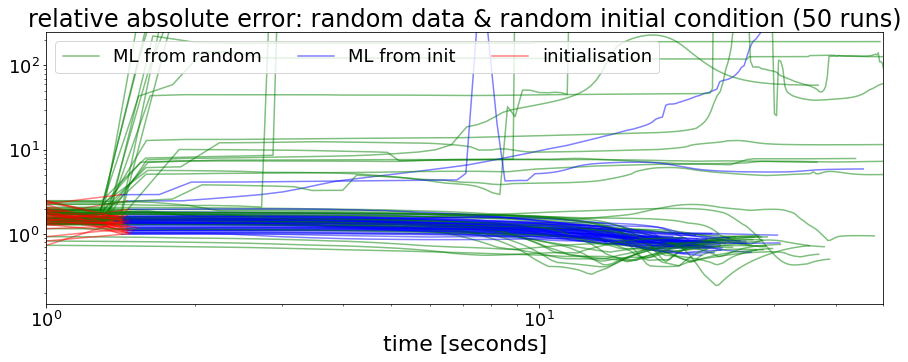

In [28]:
#plots
for i in range(runs):
    
    plt.loglog(1+model0_times[i]-model0_times[i][0],model0_errors[i], 'g', alpha=0.5, label = "ML from random" if i == 0 else "")
    plt.loglog(1+model1_times[i]-model1_times[i][0]+init_times[i],model1_errors[i], 'b', alpha=0.5, label = "ML from init" if i == 0 else "")
    plt.loglog(1+np.array([0,init_times[i]]),np.array([model0_errors[i][0], model1_errors[i][0]]), 'r', alpha=0.5, label = "initialisation" if i == 0 else "")
plt.title(r'relative absolute error: random data & random initial condition (50 runs)')
plt.legend(loc=2, ncol=3)
plt.xlabel('time [seconds]')
plt.ylim([0.15,250])
plt.xlim([1,50])
plt.savefig('../NeurIPS 2022/img/exp1_error_free.pdf', bbox_inches='tight')

